# Projet Classification de données hyperspectrales

Les images hyperspectrales sont un type de données que vous avez déjà traitées dans un précédent TP, et qui correspondent à des images dont le contenu spectral est enrichi. L'objectif de ce mini-projet est une compétition (entre vous) pour la classification des pixels d'une image hyperspectrale.



Vous allez avoir à disposition une image hyperspectrale (survol de l'Université de pavie), et votre objectif est de déterminer automatiquement la nature des pixels qui composent l'image.

On commence par charger l'image et quelques imports utiles


In [1]:
import numpy as np
from scipy.io import loadmat
import pylab as pl

In [2]:
pavia = np.load('pavia.npy')

dont voici les dimensions


In [3]:
pavia.shape

(610, 340, 103)

Voici un aperçu de cette image (on choisit 3 bandes spectrales parmi les 103 pour simuler le bleu, vert et rouge)

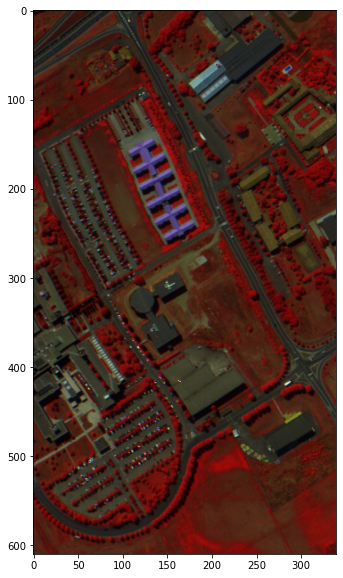

In [4]:
#print(pavia[0, 0])

nbands=[100,50,10]

pl.figure(figsize=(10,10))
pl.imshow(pavia[:,:,nbands])
pl.show()

Je donne en plus de cette image une série de labels correspondant à la classe associée à certains pixels


pavia_vt shape: (610, 340)


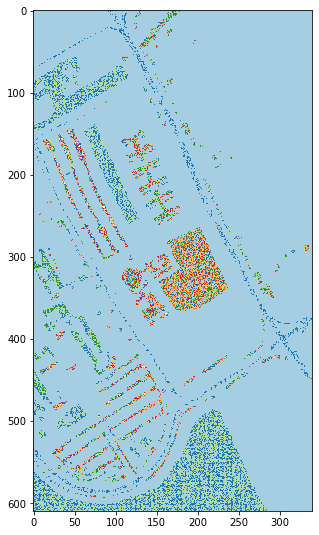

In [178]:
pavia_vt = np.load('train_set.npy')

print(f'pavia_vt shape: {pavia_vt.shape}')
#print(pavia_vt)

pl.figure(figsize=(5,10))
pl.imshow(pavia_vt,cmap='Paired')
pl.show()

Vous noterez que **la classe 0 correspond à tous les pixels à étiquetter**



L'objectif est que vous obteniez la classe de tous les autres pixels en utilisant un réseau de neurones que vous designerez selon votre choix. L'objectif est d'obtenir les meilleures performances sur ce jeu de données, aussi vous penserez à découper votre jeu de données d'entrainement en jeux de train/validation. Je vous laisse toute latitude sur ces choix. 



En plus du notebook contenant votre code, vous me remettrez un fichier dont la structure est équivalente à celle de 'train_set.npy', contenant une des 9 neufs classes numérotées de 1 à 9 **pour chaque pixel**  (un espace de rendu sera disponible dans l'ENT).

<center> <h1>RESULTS</h1> </center>

In [179]:
# seperating data
X_labeled = pavia[pavia_vt != 0]
y_labeled = pavia_vt[pavia_vt !=0 ]
print(f'[LABELED DATASET SIZE]: X: {X_labeled.shape}; y: {y_labeled.shape}' )

#remaining for prediction (not used)
X_for_prediction = pavia[pavia_vt == 0]
y_for_prediction = pavia_vt[pavia_vt ==0 ]
print(f'[DATASET FOR PREDICTION SIZE]: X: {X_for_prediction.shape}; y: {y_for_prediction.shape}' )

# split data into train test data


[LABELED DATASET SIZE]: X: (21385, 103); y: (21385,)
[DATASET FOR PREDICTION SIZE]: X: (186015, 103); y: (186015,)


## Preprocessing data

### Normalize pixel data

The value of each component in a pixel in the image data is an integer in the range `[0,255]`. For the model to work properly, these values need to be normalized to the range `[0,1]`. 
So here we create a normalization function

In [180]:
def normalize(image):
    image = image.astype(np.float32)
    image /= 255
    return image

X_labeled = normalize(X_labeled)
print(X_labeled)

[[0.14901961 0.16078432 0.17254902 ... 0.13333334 0.14117648 0.14509805]
 [0.19607843 0.18431373 0.16078432 ... 0.14117648 0.14117648 0.14509805]
 [0.14901961 0.14509805 0.14901961 ... 0.19215687 0.19607843 0.2       ]
 ...
 [0.14117648 0.12941177 0.12156863 ... 0.3254902  0.3254902  0.3254902 ]
 [0.11372549 0.12941177 0.1254902  ... 0.32941177 0.32941177 0.32941177]
 [0.09411765 0.05490196 0.05882353 ... 0.34509805 0.34117648 0.34117648]]


### Split data into train test data

In [181]:
from sklearn.model_selection import train_test_split


In [182]:
X_train, X_test, y_train, y_test = train_test_split(
    X_labeled, y_labeled, test_size=0.20, random_state=42
)

### Train data one-hote encoding

 We convert integer-encoded categorical variables as one-hot encoded values.

In [183]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical


In [184]:
print(y_train[0])

Y_train = to_categorical(y_train)

Y_test = to_categorical(y_test)

Y_train[0]
print(X_train.shape)
print(Y_train.shape)

1
(17108, 103)
(17108, 10)


In [185]:

from keras import layers
from keras import optimizers
from keras import initializers

### Model creation

In [186]:
N = X_train.shape[1]
H = 256
K = Y_train.shape[1] #

print(N, H, K)

# weights initializers
initializer_1 = initializers.RandomNormal(stddev=0.01)
initializer_2 = initializers.RandomUniform(minval=0., maxval=1.)
initializer_3 = initializers.VarianceScaling(scale=0.001, distribution='truncated_normal')

#
model = keras.Sequential(
    [
     layers.Dense(H, input_shape=[N], activation="relu", 
                  kernel_initializer=initializer_3, 
                  name="hiddenlayer1" ),
     layers.Dense(H, activation='relu', kernel_initializer=initializer_3, name='hiddenlayer2'),
     layers.Dense(H/2, activation='relu', name='hiddenlayer3'),
     layers.Dense(K, activation="softmax", name="outputlayer")
    ]
)


103 256 10


### Compiling the model

In [187]:
# compiling the model

model.compile(optimizer='adam',
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

>**Defining some callbacks**

In [188]:
# This callback will stop the training when there is no improvement in  
# the validation accuracy for three consecutive epochs. 
callback = keras.callbacks.EarlyStopping(
    monitor='val_accuracy', min_delta= 0.002, 
    patience=3, restore_best_weights= True
)


In [189]:
# custom callback to monitor the  accuracy on validation data
class ValAccuracyCallback(keras.callbacks.Callback):
    
    def __init__(self, threshold):
        super(ValAccuracyCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        val_accuracy = logs["val_accuracy"]
        if val_accuracy >= self.threshold:
            self.model.stop_training = True

### Training the model

In [190]:
val_acc_callback=ValAccuracyCallback(threshold=0.97)

history = model.fit(X_train, Y_train, 
                    batch_size=624, epochs=5000, validation_split=0.25, callbacks=[val_acc_callback]
                   )

Epoch 1/5000
21/21 [==============================] - 0s 9ms/step - loss: 2.0259 - accuracy: 0.4176 - val_loss: 1.7685 - val_accuracy: 0.4412
Epoch 2/5000
21/21 [==============================] - 0s 6ms/step - loss: 1.6190 - accuracy: 0.4368 - val_loss: 1.4503 - val_accuracy: 0.4615
Epoch 3/5000
21/21 [==============================] - ETA: 0s - loss: 1.3650 - accuracy: 0.53 - 0s 6ms/step - loss: 1.2856 - accuracy: 0.5552 - val_loss: 1.0786 - val_accuracy: 0.5913
Epoch 4/5000
21/21 [==============================] - 0s 6ms/step - loss: 0.9753 - accuracy: 0.6267 - val_loss: 0.8936 - val_accuracy: 0.6194
Epoch 5/5000
21/21 [==============================] - 0s 6ms/step - loss: 0.8657 - accuracy: 0.6405 - val_loss: 0.8327 - val_accuracy: 0.6610
Epoch 6/5000
21/21 [==============================] - 0s 6ms/step - loss: 0.8260 - accuracy: 0.6565 - val_loss: 0.8237 - val_accuracy: 0.6481
Epoch 7/5000
21/21 [==============================] - 0s 6ms/step - loss: 0.7991 - accuracy: 0.6623 - val_

Epoch 58/5000
21/21 [==============================] - 0s 7ms/step - loss: 0.4476 - accuracy: 0.8158 - val_loss: 0.4357 - val_accuracy: 0.8303
Epoch 59/5000
21/21 [==============================] - 0s 7ms/step - loss: 0.4462 - accuracy: 0.8183 - val_loss: 0.4272 - val_accuracy: 0.8363
Epoch 60/5000
21/21 [==============================] - 0s 7ms/step - loss: 0.4455 - accuracy: 0.8193 - val_loss: 0.4265 - val_accuracy: 0.8270
Epoch 61/5000
21/21 [==============================] - 0s 7ms/step - loss: 0.4427 - accuracy: 0.8176 - val_loss: 0.4206 - val_accuracy: 0.8338
Epoch 62/5000
21/21 [==============================] - 0s 7ms/step - loss: 0.4405 - accuracy: 0.8198 - val_loss: 0.4159 - val_accuracy: 0.8349
Epoch 63/5000
21/21 [==============================] - 0s 7ms/step - loss: 0.4348 - accuracy: 0.8217 - val_loss: 0.4385 - val_accuracy: 0.8176
Epoch 64/5000
21/21 [==============================] - 0s 7ms/step - loss: 0.4334 - accuracy: 0.8231 - val_loss: 0.4183 - val_accuracy: 0.8415

21/21 [==============================] - 0s 11ms/step - loss: 0.3315 - accuracy: 0.8682 - val_loss: 0.3365 - val_accuracy: 0.8665
Epoch 116/5000
21/21 [==============================] - 0s 7ms/step - loss: 0.3101 - accuracy: 0.8804 - val_loss: 0.3043 - val_accuracy: 0.8917
Epoch 117/5000
21/21 [==============================] - 0s 8ms/step - loss: 0.3052 - accuracy: 0.8818 - val_loss: 0.2972 - val_accuracy: 0.8908
Epoch 118/5000
21/21 [==============================] - 0s 8ms/step - loss: 0.3012 - accuracy: 0.8850 - val_loss: 0.2885 - val_accuracy: 0.8953
Epoch 119/5000
21/21 [==============================] - 0s 8ms/step - loss: 0.3007 - accuracy: 0.8854 - val_loss: 0.3042 - val_accuracy: 0.8833
Epoch 120/5000
21/21 [==============================] - 0s 9ms/step - loss: 0.3074 - accuracy: 0.8808 - val_loss: 0.2963 - val_accuracy: 0.8901
Epoch 121/5000
21/21 [==============================] - 0s 9ms/step - loss: 0.2937 - accuracy: 0.8873 - val_loss: 0.2988 - val_accuracy: 0.8927
Epoch 

Epoch 172/5000
21/21 [==============================] - 0s 9ms/step - loss: 0.2418 - accuracy: 0.9079 - val_loss: 0.2503 - val_accuracy: 0.9112
Epoch 173/5000
21/21 [==============================] - 0s 9ms/step - loss: 0.2484 - accuracy: 0.9066 - val_loss: 0.2428 - val_accuracy: 0.9182
Epoch 174/5000
21/21 [==============================] - 0s 9ms/step - loss: 0.2250 - accuracy: 0.9172 - val_loss: 0.2490 - val_accuracy: 0.9179
Epoch 175/5000
21/21 [==============================] - 0s 9ms/step - loss: 0.2199 - accuracy: 0.9207 - val_loss: 0.2471 - val_accuracy: 0.9144
Epoch 176/5000
21/21 [==============================] - 0s 9ms/step - loss: 0.2219 - accuracy: 0.9175 - val_loss: 0.2671 - val_accuracy: 0.9048
Epoch 177/5000
21/21 [==============================] - 0s 10ms/step - loss: 0.2483 - accuracy: 0.9049 - val_loss: 0.3697 - val_accuracy: 0.8560
Epoch 178/5000
21/21 [==============================] - 0s 12ms/step - loss: 0.2563 - accuracy: 0.9012 - val_loss: 0.2813 - val_accurac

Epoch 229/5000
21/21 [==============================] - 0s 8ms/step - loss: 0.2132 - accuracy: 0.9207 - val_loss: 0.2388 - val_accuracy: 0.9210
Epoch 230/5000
21/21 [==============================] - 0s 7ms/step - loss: 0.2037 - accuracy: 0.9241 - val_loss: 0.3308 - val_accuracy: 0.8768
Epoch 231/5000
21/21 [==============================] - 0s 8ms/step - loss: 0.2049 - accuracy: 0.9222 - val_loss: 0.2272 - val_accuracy: 0.9268
Epoch 232/5000
21/21 [==============================] - 0s 8ms/step - loss: 0.1857 - accuracy: 0.9313 - val_loss: 0.2276 - val_accuracy: 0.9280
Epoch 233/5000
21/21 [==============================] - 0s 7ms/step - loss: 0.1884 - accuracy: 0.9285 - val_loss: 0.2319 - val_accuracy: 0.9271
Epoch 234/5000
21/21 [==============================] - 0s 7ms/step - loss: 0.1942 - accuracy: 0.9261 - val_loss: 0.2598 - val_accuracy: 0.9142
Epoch 235/5000
21/21 [==============================] - 0s 7ms/step - loss: 0.2129 - accuracy: 0.9205 - val_loss: 0.2383 - val_accuracy:

Epoch 286/5000
21/21 [==============================] - 0s 17ms/step - loss: 0.1718 - accuracy: 0.9366 - val_loss: 0.2143 - val_accuracy: 0.9357
Epoch 287/5000
21/21 [==============================] - 0s 18ms/step - loss: 0.1670 - accuracy: 0.9391 - val_loss: 0.2230 - val_accuracy: 0.9310
Epoch 288/5000
21/21 [==============================] - 0s 17ms/step - loss: 0.1758 - accuracy: 0.9330 - val_loss: 0.2244 - val_accuracy: 0.9329
Epoch 289/5000
21/21 [==============================] - 0s 17ms/step - loss: 0.1676 - accuracy: 0.9384 - val_loss: 0.2362 - val_accuracy: 0.9245
Epoch 290/5000
21/21 [==============================] - 0s 17ms/step - loss: 0.1688 - accuracy: 0.9373 - val_loss: 0.2294 - val_accuracy: 0.9287
Epoch 291/5000
21/21 [==============================] - 0s 17ms/step - loss: 0.1704 - accuracy: 0.9368 - val_loss: 0.2270 - val_accuracy: 0.9313
Epoch 292/5000
21/21 [==============================] - 0s 17ms/step - loss: 0.1645 - accuracy: 0.9389 - val_loss: 0.2448 - val_ac

Epoch 399/5000
21/21 [==============================] - 0s 17ms/step - loss: 0.1394 - accuracy: 0.9493 - val_loss: 0.2465 - val_accuracy: 0.9228
Epoch 400/5000
21/21 [==============================] - 0s 17ms/step - loss: 0.1546 - accuracy: 0.9413 - val_loss: 0.2518 - val_accuracy: 0.9198
Epoch 401/5000
21/21 [==============================] - 0s 17ms/step - loss: 0.1964 - accuracy: 0.9268 - val_loss: 0.2293 - val_accuracy: 0.9301
Epoch 402/5000
21/21 [==============================] - 0s 17ms/step - loss: 0.1599 - accuracy: 0.9391 - val_loss: 0.2156 - val_accuracy: 0.9343
Epoch 403/5000
21/21 [==============================] - 0s 19ms/step - loss: 0.1416 - accuracy: 0.9490 - val_loss: 0.2037 - val_accuracy: 0.9399
Epoch 404/5000
21/21 [==============================] - 0s 17ms/step - loss: 0.1434 - accuracy: 0.9472 - val_loss: 0.2134 - val_accuracy: 0.9359
Epoch 405/5000
21/21 [==============================] - 0s 18ms/step - loss: 0.1414 - accuracy: 0.9483 - val_loss: 0.2073 - val_ac

Epoch 512/5000
21/21 [==============================] - 0s 8ms/step - loss: 0.1223 - accuracy: 0.9553 - val_loss: 0.2007 - val_accuracy: 0.9434
Epoch 513/5000
21/21 [==============================] - 0s 8ms/step - loss: 0.1264 - accuracy: 0.9525 - val_loss: 0.2014 - val_accuracy: 0.9385
Epoch 514/5000
21/21 [==============================] - 0s 8ms/step - loss: 0.1433 - accuracy: 0.9457 - val_loss: 0.1863 - val_accuracy: 0.9455
Epoch 515/5000
21/21 [==============================] - 0s 8ms/step - loss: 0.1303 - accuracy: 0.9504 - val_loss: 0.1857 - val_accuracy: 0.9439
Epoch 516/5000
21/21 [==============================] - 0s 8ms/step - loss: 0.1249 - accuracy: 0.9514 - val_loss: 0.2453 - val_accuracy: 0.9193
Epoch 517/5000
21/21 [==============================] - 0s 8ms/step - loss: 0.1404 - accuracy: 0.9469 - val_loss: 0.1932 - val_accuracy: 0.9418
Epoch 518/5000
21/21 [==============================] - 0s 8ms/step - loss: 0.1304 - accuracy: 0.9504 - val_loss: 0.1837 - val_accuracy:

Epoch 569/5000
21/21 [==============================] - 0s 17ms/step - loss: 0.1307 - accuracy: 0.9507 - val_loss: 0.1890 - val_accuracy: 0.9430
Epoch 570/5000
21/21 [==============================] - 0s 18ms/step - loss: 0.1234 - accuracy: 0.9532 - val_loss: 0.2065 - val_accuracy: 0.9385
Epoch 571/5000
21/21 [==============================] - 0s 18ms/step - loss: 0.1236 - accuracy: 0.9546 - val_loss: 0.1824 - val_accuracy: 0.9467
Epoch 572/5000
21/21 [==============================] - 0s 18ms/step - loss: 0.1134 - accuracy: 0.9560 - val_loss: 0.1782 - val_accuracy: 0.9479
Epoch 573/5000
21/21 [==============================] - 0s 18ms/step - loss: 0.1130 - accuracy: 0.9569 - val_loss: 0.1800 - val_accuracy: 0.9495
Epoch 574/5000
21/21 [==============================] - 0s 17ms/step - loss: 0.1139 - accuracy: 0.9573 - val_loss: 0.1985 - val_accuracy: 0.9397
Epoch 575/5000
21/21 [==============================] - 0s 13ms/step - loss: 0.1168 - accuracy: 0.9566 - val_loss: 0.2006 - val_ac

Epoch 626/5000
21/21 [==============================] - 0s 20ms/step - loss: 0.1169 - accuracy: 0.9560 - val_loss: 0.1737 - val_accuracy: 0.9488
Epoch 627/5000
21/21 [==============================] - 0s 19ms/step - loss: 0.1128 - accuracy: 0.9561 - val_loss: 0.1735 - val_accuracy: 0.9500
Epoch 628/5000
21/21 [==============================] - 0s 19ms/step - loss: 0.1073 - accuracy: 0.9592 - val_loss: 0.1788 - val_accuracy: 0.9521
Epoch 629/5000
21/21 [==============================] - 0s 18ms/step - loss: 0.1071 - accuracy: 0.9600 - val_loss: 0.1714 - val_accuracy: 0.9514
Epoch 630/5000
21/21 [==============================] - 0s 17ms/step - loss: 0.1165 - accuracy: 0.9569 - val_loss: 0.1866 - val_accuracy: 0.9444
Epoch 631/5000
21/21 [==============================] - 0s 22ms/step - loss: 0.1079 - accuracy: 0.9588 - val_loss: 0.1760 - val_accuracy: 0.9455
Epoch 632/5000
21/21 [==============================] - 0s 18ms/step - loss: 0.1061 - accuracy: 0.9613 - val_loss: 0.1676 - val_ac

21/21 [==============================] - 0s 17ms/step - loss: 0.1123 - accuracy: 0.9580 - val_loss: 0.1770 - val_accuracy: 0.9488
Epoch 739/5000
21/21 [==============================] - 0s 16ms/step - loss: 0.1068 - accuracy: 0.9594 - val_loss: 0.1965 - val_accuracy: 0.9341
Epoch 740/5000
21/21 [==============================] - 0s 16ms/step - loss: 0.1070 - accuracy: 0.9574 - val_loss: 0.1734 - val_accuracy: 0.9483
Epoch 741/5000
21/21 [==============================] - 0s 16ms/step - loss: 0.0998 - accuracy: 0.9618 - val_loss: 0.1703 - val_accuracy: 0.9509
Epoch 742/5000
21/21 [==============================] - 0s 16ms/step - loss: 0.1003 - accuracy: 0.9617 - val_loss: 0.1727 - val_accuracy: 0.9479
Epoch 743/5000
21/21 [==============================] - 0s 16ms/step - loss: 0.1076 - accuracy: 0.9578 - val_loss: 0.1654 - val_accuracy: 0.9497
Epoch 744/5000
21/21 [==============================] - 0s 17ms/step - loss: 0.1079 - accuracy: 0.9592 - val_loss: 0.1680 - val_accuracy: 0.9560


Epoch 795/5000
21/21 [==============================] - 0s 13ms/step - loss: 0.0890 - accuracy: 0.9667 - val_loss: 0.1552 - val_accuracy: 0.9565
Epoch 796/5000
21/21 [==============================] - 0s 14ms/step - loss: 0.0926 - accuracy: 0.9655 - val_loss: 0.1570 - val_accuracy: 0.9560
Epoch 797/5000
21/21 [==============================] - 0s 14ms/step - loss: 0.0944 - accuracy: 0.9631 - val_loss: 0.1678 - val_accuracy: 0.9495
Epoch 798/5000
21/21 [==============================] - 0s 14ms/step - loss: 0.0958 - accuracy: 0.9632 - val_loss: 0.1675 - val_accuracy: 0.9551
Epoch 799/5000
21/21 [==============================] - 0s 14ms/step - loss: 0.0928 - accuracy: 0.9637 - val_loss: 0.1754 - val_accuracy: 0.9493
Epoch 800/5000
21/21 [==============================] - 0s 14ms/step - loss: 0.0913 - accuracy: 0.9651 - val_loss: 0.1757 - val_accuracy: 0.9472
Epoch 801/5000
21/21 [==============================] - 0s 15ms/step - loss: 0.0935 - accuracy: 0.9645 - val_loss: 0.1780 - val_ac

21/21 [==============================] - 0s 16ms/step - loss: 0.0921 - accuracy: 0.9652 - val_loss: 0.1575 - val_accuracy: 0.9572
Epoch 908/5000
21/21 [==============================] - 0s 16ms/step - loss: 0.0888 - accuracy: 0.9650 - val_loss: 0.1635 - val_accuracy: 0.9542
Epoch 909/5000
21/21 [==============================] - 0s 16ms/step - loss: 0.0931 - accuracy: 0.9625 - val_loss: 0.1776 - val_accuracy: 0.9479
Epoch 910/5000
21/21 [==============================] - 0s 16ms/step - loss: 0.0892 - accuracy: 0.9666 - val_loss: 0.1613 - val_accuracy: 0.9544
Epoch 911/5000
21/21 [==============================] - 0s 16ms/step - loss: 0.0830 - accuracy: 0.9681 - val_loss: 0.1577 - val_accuracy: 0.9560
Epoch 912/5000
21/21 [==============================] - 0s 16ms/step - loss: 0.0851 - accuracy: 0.9680 - val_loss: 0.1751 - val_accuracy: 0.9495
Epoch 913/5000
21/21 [==============================] - 0s 20ms/step - loss: 0.0987 - accuracy: 0.9607 - val_loss: 0.1868 - val_accuracy: 0.9441


Epoch 964/5000
21/21 [==============================] - 0s 21ms/step - loss: 0.1065 - accuracy: 0.9578 - val_loss: 0.1700 - val_accuracy: 0.9509
Epoch 965/5000
21/21 [==============================] - 0s 18ms/step - loss: 0.0871 - accuracy: 0.9673 - val_loss: 0.1541 - val_accuracy: 0.9581
Epoch 966/5000
21/21 [==============================] - 0s 18ms/step - loss: 0.0810 - accuracy: 0.9680 - val_loss: 0.1612 - val_accuracy: 0.9558
Epoch 967/5000
21/21 [==============================] - 0s 19ms/step - loss: 0.0788 - accuracy: 0.9686 - val_loss: 0.1591 - val_accuracy: 0.9542
Epoch 968/5000
21/21 [==============================] - 0s 20ms/step - loss: 0.0786 - accuracy: 0.9697 - val_loss: 0.1619 - val_accuracy: 0.9530
Epoch 969/5000
21/21 [==============================] - 0s 18ms/step - loss: 0.0841 - accuracy: 0.9674 - val_loss: 0.1669 - val_accuracy: 0.9514
Epoch 970/5000
21/21 [==============================] - 0s 15ms/step - loss: 0.0763 - accuracy: 0.9707 - val_loss: 0.1915 - val_ac

21/21 [==============================] - 0s 7ms/step - loss: 0.0733 - accuracy: 0.9729 - val_loss: 0.1675 - val_accuracy: 0.9514
Epoch 1077/5000
21/21 [==============================] - 0s 7ms/step - loss: 0.0782 - accuracy: 0.9698 - val_loss: 0.1581 - val_accuracy: 0.9546
Epoch 1078/5000
21/21 [==============================] - 0s 7ms/step - loss: 0.0714 - accuracy: 0.9729 - val_loss: 0.1634 - val_accuracy: 0.9551
Epoch 1079/5000
21/21 [==============================] - 0s 7ms/step - loss: 0.0763 - accuracy: 0.9705 - val_loss: 0.2037 - val_accuracy: 0.9399
Epoch 1080/5000
21/21 [==============================] - 0s 7ms/step - loss: 0.0916 - accuracy: 0.9652 - val_loss: 0.1660 - val_accuracy: 0.9530
Epoch 1081/5000
21/21 [==============================] - 0s 7ms/step - loss: 0.0727 - accuracy: 0.9722 - val_loss: 0.1618 - val_accuracy: 0.9551
Epoch 1082/5000
21/21 [==============================] - 0s 7ms/step - loss: 0.0709 - accuracy: 0.9720 - val_loss: 0.1714 - val_accuracy: 0.9518
E

21/21 [==============================] - 0s 7ms/step - loss: 0.0904 - accuracy: 0.9634 - val_loss: 0.2050 - val_accuracy: 0.9460
Epoch 1189/5000
21/21 [==============================] - 0s 7ms/step - loss: 0.0807 - accuracy: 0.9677 - val_loss: 0.1684 - val_accuracy: 0.9572
Epoch 1190/5000
21/21 [==============================] - 0s 7ms/step - loss: 0.0741 - accuracy: 0.9709 - val_loss: 0.1687 - val_accuracy: 0.9553
Epoch 1191/5000
21/21 [==============================] - 0s 7ms/step - loss: 0.0680 - accuracy: 0.9724 - val_loss: 0.1802 - val_accuracy: 0.9467
Epoch 1192/5000
21/21 [==============================] - 0s 7ms/step - loss: 0.0674 - accuracy: 0.9744 - val_loss: 0.1654 - val_accuracy: 0.9546
Epoch 1193/5000
21/21 [==============================] - 0s 7ms/step - loss: 0.0664 - accuracy: 0.9740 - val_loss: 0.1603 - val_accuracy: 0.9586
Epoch 1194/5000
21/21 [==============================] - 0s 7ms/step - loss: 0.0771 - accuracy: 0.9689 - val_loss: 0.2001 - val_accuracy: 0.9441
E

21/21 [==============================] - 0s 16ms/step - loss: 0.0657 - accuracy: 0.9751 - val_loss: 0.1791 - val_accuracy: 0.9521
Epoch 1301/5000
21/21 [==============================] - 0s 20ms/step - loss: 0.0672 - accuracy: 0.9730 - val_loss: 0.1756 - val_accuracy: 0.9530
Epoch 1302/5000
21/21 [==============================] - 0s 16ms/step - loss: 0.0668 - accuracy: 0.9723 - val_loss: 0.1914 - val_accuracy: 0.9493
Epoch 1303/5000
21/21 [==============================] - 0s 16ms/step - loss: 0.0649 - accuracy: 0.9736 - val_loss: 0.1744 - val_accuracy: 0.9551
Epoch 1304/5000
21/21 [==============================] - 0s 16ms/step - loss: 0.0705 - accuracy: 0.9721 - val_loss: 0.1880 - val_accuracy: 0.9497
Epoch 1305/5000
21/21 [==============================] - 0s 16ms/step - loss: 0.0735 - accuracy: 0.9712 - val_loss: 0.1842 - val_accuracy: 0.9490
Epoch 1306/5000
21/21 [==============================] - 0s 14ms/step - loss: 0.0696 - accuracy: 0.9709 - val_loss: 0.1762 - val_accuracy: 0

21/21 [==============================] - 0s 16ms/step - loss: 0.0650 - accuracy: 0.9741 - val_loss: 0.1713 - val_accuracy: 0.9567
Epoch 1413/5000
21/21 [==============================] - 0s 16ms/step - loss: 0.0634 - accuracy: 0.9764 - val_loss: 0.1745 - val_accuracy: 0.9558
Epoch 1414/5000
21/21 [==============================] - 0s 16ms/step - loss: 0.0656 - accuracy: 0.9751 - val_loss: 0.1819 - val_accuracy: 0.9546
Epoch 1415/5000
21/21 [==============================] - 0s 14ms/step - loss: 0.0796 - accuracy: 0.9675 - val_loss: 0.1820 - val_accuracy: 0.9502
Epoch 1416/5000
21/21 [==============================] - 0s 14ms/step - loss: 0.0683 - accuracy: 0.9733 - val_loss: 0.1872 - val_accuracy: 0.9539
Epoch 1417/5000
21/21 [==============================] - 0s 14ms/step - loss: 0.0675 - accuracy: 0.9730 - val_loss: 0.1870 - val_accuracy: 0.9509
Epoch 1418/5000
21/21 [==============================] - 0s 14ms/step - loss: 0.0586 - accuracy: 0.9774 - val_loss: 0.1699 - val_accuracy: 0

21/21 [==============================] - 0s 14ms/step - loss: 0.0612 - accuracy: 0.9754 - val_loss: 0.1947 - val_accuracy: 0.9460
Epoch 1525/5000
21/21 [==============================] - 0s 14ms/step - loss: 0.0617 - accuracy: 0.9754 - val_loss: 0.2008 - val_accuracy: 0.9458
Epoch 1526/5000
21/21 [==============================] - 0s 15ms/step - loss: 0.0649 - accuracy: 0.9740 - val_loss: 0.1822 - val_accuracy: 0.9542
Epoch 1527/5000
21/21 [==============================] - 0s 15ms/step - loss: 0.0588 - accuracy: 0.9762 - val_loss: 0.1996 - val_accuracy: 0.9532
Epoch 1528/5000
21/21 [==============================] - 0s 15ms/step - loss: 0.0566 - accuracy: 0.9772 - val_loss: 0.1827 - val_accuracy: 0.9558
Epoch 1529/5000
21/21 [==============================] - 0s 17ms/step - loss: 0.0557 - accuracy: 0.9772 - val_loss: 0.1865 - val_accuracy: 0.9535
Epoch 1530/5000
21/21 [==============================] - 0s 16ms/step - loss: 0.0570 - accuracy: 0.9779 - val_loss: 0.1952 - val_accuracy: 0

21/21 [==============================] - 0s 17ms/step - loss: 0.0712 - accuracy: 0.9712 - val_loss: 0.1960 - val_accuracy: 0.9518
Epoch 1637/5000
21/21 [==============================] - 0s 19ms/step - loss: 0.0962 - accuracy: 0.9603 - val_loss: 0.1862 - val_accuracy: 0.9514
Epoch 1638/5000
21/21 [==============================] - 0s 18ms/step - loss: 0.0632 - accuracy: 0.9740 - val_loss: 0.2031 - val_accuracy: 0.9488
Epoch 1639/5000
21/21 [==============================] - 0s 18ms/step - loss: 0.0553 - accuracy: 0.9779 - val_loss: 0.1912 - val_accuracy: 0.9542
Epoch 1640/5000
21/21 [==============================] - 0s 16ms/step - loss: 0.0467 - accuracy: 0.9818 - val_loss: 0.1993 - val_accuracy: 0.9500
Epoch 1641/5000
21/21 [==============================] - 0s 17ms/step - loss: 0.0504 - accuracy: 0.9800 - val_loss: 0.1893 - val_accuracy: 0.9537
Epoch 1642/5000
21/21 [==============================] - 0s 16ms/step - loss: 0.0485 - accuracy: 0.9815 - val_loss: 0.1816 - val_accuracy: 0

21/21 [==============================] - 0s 11ms/step - loss: 0.0561 - accuracy: 0.9772 - val_loss: 0.1955 - val_accuracy: 0.9551
Epoch 1749/5000
21/21 [==============================] - 0s 11ms/step - loss: 0.0495 - accuracy: 0.9788 - val_loss: 0.1914 - val_accuracy: 0.9530
Epoch 1750/5000
21/21 [==============================] - 0s 10ms/step - loss: 0.0500 - accuracy: 0.9801 - val_loss: 0.1966 - val_accuracy: 0.9567
Epoch 1751/5000
21/21 [==============================] - 0s 12ms/step - loss: 0.0572 - accuracy: 0.9772 - val_loss: 0.2042 - val_accuracy: 0.9500
Epoch 1752/5000
21/21 [==============================] - 0s 11ms/step - loss: 0.0732 - accuracy: 0.9710 - val_loss: 0.2344 - val_accuracy: 0.9401
Epoch 1753/5000
21/21 [==============================] - 0s 10ms/step - loss: 0.0682 - accuracy: 0.9725 - val_loss: 0.1906 - val_accuracy: 0.9567
Epoch 1754/5000
21/21 [==============================] - 0s 10ms/step - loss: 0.0474 - accuracy: 0.9815 - val_loss: 0.2046 - val_accuracy: 0

21/21 [==============================] - 0s 18ms/step - loss: 0.0604 - accuracy: 0.9754 - val_loss: 0.2263 - val_accuracy: 0.9476
Epoch 1861/5000
21/21 [==============================] - 0s 17ms/step - loss: 0.0530 - accuracy: 0.9797 - val_loss: 0.2103 - val_accuracy: 0.9532
Epoch 1862/5000
21/21 [==============================] - 0s 17ms/step - loss: 0.0485 - accuracy: 0.9803 - val_loss: 0.1908 - val_accuracy: 0.9577
Epoch 1863/5000
21/21 [==============================] - 0s 17ms/step - loss: 0.0393 - accuracy: 0.9851 - val_loss: 0.2078 - val_accuracy: 0.9567
Epoch 1864/5000
21/21 [==============================] - 0s 18ms/step - loss: 0.0435 - accuracy: 0.9822 - val_loss: 0.1959 - val_accuracy: 0.9556
Epoch 1865/5000
21/21 [==============================] - 0s 17ms/step - loss: 0.0448 - accuracy: 0.9824 - val_loss: 0.2030 - val_accuracy: 0.9525
Epoch 1866/5000
21/21 [==============================] - 0s 17ms/step - loss: 0.0444 - accuracy: 0.9808 - val_loss: 0.1968 - val_accuracy: 0

21/21 [==============================] - 0s 18ms/step - loss: 0.0491 - accuracy: 0.9800 - val_loss: 0.2138 - val_accuracy: 0.9486
Epoch 1973/5000
21/21 [==============================] - 0s 19ms/step - loss: 0.0382 - accuracy: 0.9853 - val_loss: 0.2090 - val_accuracy: 0.9558
Epoch 1974/5000
21/21 [==============================] - 1s 25ms/step - loss: 0.0368 - accuracy: 0.9864 - val_loss: 0.2080 - val_accuracy: 0.9563
Epoch 1975/5000
21/21 [==============================] - 0s 20ms/step - loss: 0.0399 - accuracy: 0.9842 - val_loss: 0.2025 - val_accuracy: 0.9577
Epoch 1976/5000
21/21 [==============================] - 0s 22ms/step - loss: 0.0367 - accuracy: 0.9860 - val_loss: 0.2058 - val_accuracy: 0.9558
Epoch 1977/5000
21/21 [==============================] - 0s 19ms/step - loss: 0.0373 - accuracy: 0.9857 - val_loss: 0.2054 - val_accuracy: 0.9600
Epoch 1978/5000
21/21 [==============================] - 0s 19ms/step - loss: 0.0401 - accuracy: 0.9843 - val_loss: 0.2036 - val_accuracy: 0

21/21 [==============================] - 0s 7ms/step - loss: 0.0570 - accuracy: 0.9765 - val_loss: 0.2700 - val_accuracy: 0.9422
Epoch 2085/5000
21/21 [==============================] - 0s 8ms/step - loss: 0.0567 - accuracy: 0.9768 - val_loss: 0.2360 - val_accuracy: 0.9532
Epoch 2086/5000
21/21 [==============================] - 0s 8ms/step - loss: 0.0381 - accuracy: 0.9853 - val_loss: 0.2228 - val_accuracy: 0.9535
Epoch 2087/5000
21/21 [==============================] - 0s 8ms/step - loss: 0.0401 - accuracy: 0.9853 - val_loss: 0.2288 - val_accuracy: 0.9553
Epoch 2088/5000
21/21 [==============================] - 0s 7ms/step - loss: 0.0419 - accuracy: 0.9830 - val_loss: 0.2421 - val_accuracy: 0.9441
Epoch 2089/5000
21/21 [==============================] - 0s 7ms/step - loss: 0.0427 - accuracy: 0.9830 - val_loss: 0.2153 - val_accuracy: 0.9577
Epoch 2090/5000
21/21 [==============================] - 0s 7ms/step - loss: 0.0369 - accuracy: 0.9860 - val_loss: 0.2274 - val_accuracy: 0.9521
E

21/21 [==============================] - 0s 17ms/step - loss: 0.0438 - accuracy: 0.9820 - val_loss: 0.2294 - val_accuracy: 0.9558
Epoch 2197/5000
21/21 [==============================] - 0s 18ms/step - loss: 0.0356 - accuracy: 0.9864 - val_loss: 0.2338 - val_accuracy: 0.9507
Epoch 2198/5000
21/21 [==============================] - 0s 18ms/step - loss: 0.0641 - accuracy: 0.9753 - val_loss: 0.2347 - val_accuracy: 0.9504
Epoch 2199/5000
21/21 [==============================] - 0s 19ms/step - loss: 0.0456 - accuracy: 0.9825 - val_loss: 0.2457 - val_accuracy: 0.9523
Epoch 2200/5000
21/21 [==============================] - 0s 17ms/step - loss: 0.0505 - accuracy: 0.9804 - val_loss: 0.2277 - val_accuracy: 0.9537
Epoch 2201/5000
21/21 [==============================] - 0s 18ms/step - loss: 0.0396 - accuracy: 0.9837 - val_loss: 0.2211 - val_accuracy: 0.9549
Epoch 2202/5000
21/21 [==============================] - 0s 18ms/step - loss: 0.0354 - accuracy: 0.9870 - val_loss: 0.2377 - val_accuracy: 0

21/21 [==============================] - 0s 19ms/step - loss: 0.0374 - accuracy: 0.9853 - val_loss: 0.2306 - val_accuracy: 0.9581
Epoch 2309/5000
21/21 [==============================] - 0s 17ms/step - loss: 0.0378 - accuracy: 0.9862 - val_loss: 0.2258 - val_accuracy: 0.9560
Epoch 2310/5000
21/21 [==============================] - 0s 22ms/step - loss: 0.0344 - accuracy: 0.9872 - val_loss: 0.2380 - val_accuracy: 0.9523
Epoch 2311/5000
21/21 [==============================] - 0s 18ms/step - loss: 0.0336 - accuracy: 0.9875 - val_loss: 0.2543 - val_accuracy: 0.9500
Epoch 2312/5000
21/21 [==============================] - 0s 16ms/step - loss: 0.0386 - accuracy: 0.9850 - val_loss: 0.2278 - val_accuracy: 0.9579
Epoch 2313/5000
21/21 [==============================] - 0s 18ms/step - loss: 0.0389 - accuracy: 0.9863 - val_loss: 0.2233 - val_accuracy: 0.9577
Epoch 2314/5000
21/21 [==============================] - 0s 17ms/step - loss: 0.0358 - accuracy: 0.9856 - val_loss: 0.2340 - val_accuracy: 0

21/21 [==============================] - 0s 8ms/step - loss: 0.0397 - accuracy: 0.9833 - val_loss: 0.2412 - val_accuracy: 0.9542
Epoch 2421/5000
21/21 [==============================] - 0s 8ms/step - loss: 0.0369 - accuracy: 0.9843 - val_loss: 0.2392 - val_accuracy: 0.9553
Epoch 2422/5000
21/21 [==============================] - 0s 8ms/step - loss: 0.0396 - accuracy: 0.9845 - val_loss: 0.2578 - val_accuracy: 0.9500
Epoch 2423/5000
21/21 [==============================] - 0s 8ms/step - loss: 0.0503 - accuracy: 0.9800 - val_loss: 0.2290 - val_accuracy: 0.9546
Epoch 2424/5000
21/21 [==============================] - 0s 8ms/step - loss: 0.0287 - accuracy: 0.9899 - val_loss: 0.2385 - val_accuracy: 0.9537
Epoch 2425/5000
21/21 [==============================] - 0s 8ms/step - loss: 0.0312 - accuracy: 0.9875 - val_loss: 0.2351 - val_accuracy: 0.9553
Epoch 2426/5000
21/21 [==============================] - 0s 7ms/step - loss: 0.0359 - accuracy: 0.9867 - val_loss: 0.2361 - val_accuracy: 0.9539
E

21/21 [==============================] - 0s 8ms/step - loss: 0.0472 - accuracy: 0.9818 - val_loss: 0.2450 - val_accuracy: 0.9565
Epoch 2533/5000
21/21 [==============================] - 0s 8ms/step - loss: 0.0379 - accuracy: 0.9854 - val_loss: 0.2595 - val_accuracy: 0.9549
Epoch 2534/5000
21/21 [==============================] - 0s 8ms/step - loss: 0.0316 - accuracy: 0.9882 - val_loss: 0.2363 - val_accuracy: 0.9577
Epoch 2535/5000
21/21 [==============================] - 0s 8ms/step - loss: 0.0301 - accuracy: 0.9895 - val_loss: 0.2555 - val_accuracy: 0.9518
Epoch 2536/5000
21/21 [==============================] - 0s 8ms/step - loss: 0.0355 - accuracy: 0.9862 - val_loss: 0.2582 - val_accuracy: 0.9516
Epoch 2537/5000
21/21 [==============================] - 0s 8ms/step - loss: 0.0473 - accuracy: 0.9812 - val_loss: 0.2690 - val_accuracy: 0.9476
Epoch 2538/5000
21/21 [==============================] - 0s 8ms/step - loss: 0.0456 - accuracy: 0.9815 - val_loss: 0.2727 - val_accuracy: 0.9469
E

21/21 [==============================] - 0s 19ms/step - loss: 0.0256 - accuracy: 0.9913 - val_loss: 0.2528 - val_accuracy: 0.9563
Epoch 2645/5000
21/21 [==============================] - 0s 17ms/step - loss: 0.0249 - accuracy: 0.9904 - val_loss: 0.2717 - val_accuracy: 0.9530
Epoch 2646/5000
21/21 [==============================] - 0s 17ms/step - loss: 0.0362 - accuracy: 0.9862 - val_loss: 0.2646 - val_accuracy: 0.9544
Epoch 2647/5000
21/21 [==============================] - 0s 18ms/step - loss: 0.0409 - accuracy: 0.9845 - val_loss: 0.2709 - val_accuracy: 0.9514
Epoch 2648/5000
21/21 [==============================] - 0s 18ms/step - loss: 0.0312 - accuracy: 0.9875 - val_loss: 0.2483 - val_accuracy: 0.9570
Epoch 2649/5000
21/21 [==============================] - 0s 17ms/step - loss: 0.0255 - accuracy: 0.9913 - val_loss: 0.2567 - val_accuracy: 0.9570
Epoch 2650/5000
21/21 [==============================] - 0s 17ms/step - loss: 0.0294 - accuracy: 0.9884 - val_loss: 0.2618 - val_accuracy: 0

21/21 [==============================] - 0s 8ms/step - loss: 0.0214 - accuracy: 0.9922 - val_loss: 0.2662 - val_accuracy: 0.9521
Epoch 2757/5000
21/21 [==============================] - 0s 8ms/step - loss: 0.0276 - accuracy: 0.9893 - val_loss: 0.2655 - val_accuracy: 0.9516
Epoch 2758/5000
21/21 [==============================] - 0s 8ms/step - loss: 0.0361 - accuracy: 0.9850 - val_loss: 0.3536 - val_accuracy: 0.9371
Epoch 2759/5000
21/21 [==============================] - 0s 8ms/step - loss: 0.3042 - accuracy: 0.9239 - val_loss: 0.3525 - val_accuracy: 0.9200
Epoch 2760/5000
21/21 [==============================] - 0s 8ms/step - loss: 0.1269 - accuracy: 0.9532 - val_loss: 0.2621 - val_accuracy: 0.9507
Epoch 2761/5000
21/21 [==============================] - 0s 8ms/step - loss: 0.0599 - accuracy: 0.9772 - val_loss: 0.2570 - val_accuracy: 0.9509
Epoch 2762/5000
21/21 [==============================] - 0s 8ms/step - loss: 0.0445 - accuracy: 0.9832 - val_loss: 0.2592 - val_accuracy: 0.9521
E

21/21 [==============================] - 0s 10ms/step - loss: 0.0216 - accuracy: 0.9925 - val_loss: 0.2724 - val_accuracy: 0.9537
Epoch 2869/5000
21/21 [==============================] - 0s 9ms/step - loss: 0.0233 - accuracy: 0.9915 - val_loss: 0.3071 - val_accuracy: 0.9451
Epoch 2870/5000
21/21 [==============================] - 0s 9ms/step - loss: 0.0412 - accuracy: 0.9846 - val_loss: 0.3458 - val_accuracy: 0.9401
Epoch 2871/5000
21/21 [==============================] - 0s 9ms/step - loss: 0.0445 - accuracy: 0.9824 - val_loss: 0.2905 - val_accuracy: 0.9514
Epoch 2872/5000
21/21 [==============================] - 0s 9ms/step - loss: 0.0363 - accuracy: 0.9853 - val_loss: 0.2937 - val_accuracy: 0.9493
Epoch 2873/5000
21/21 [==============================] - 0s 9ms/step - loss: 0.0377 - accuracy: 0.9853 - val_loss: 0.2831 - val_accuracy: 0.9514
Epoch 2874/5000
21/21 [==============================] - 0s 9ms/step - loss: 0.0329 - accuracy: 0.9871 - val_loss: 0.2656 - val_accuracy: 0.9558


21/21 [==============================] - 0s 20ms/step - loss: 0.0232 - accuracy: 0.9912 - val_loss: 0.2816 - val_accuracy: 0.9537
Epoch 2981/5000
21/21 [==============================] - 0s 14ms/step - loss: 0.0192 - accuracy: 0.9935 - val_loss: 0.2844 - val_accuracy: 0.9544
Epoch 2982/5000
21/21 [==============================] - 0s 9ms/step - loss: 0.0212 - accuracy: 0.9925 - val_loss: 0.2870 - val_accuracy: 0.9537
Epoch 2983/5000
21/21 [==============================] - 0s 8ms/step - loss: 0.0254 - accuracy: 0.9907 - val_loss: 0.2803 - val_accuracy: 0.9537
Epoch 2984/5000
21/21 [==============================] - 0s 7ms/step - loss: 0.0221 - accuracy: 0.9917 - val_loss: 0.2913 - val_accuracy: 0.9549
Epoch 2985/5000
21/21 [==============================] - 0s 7ms/step - loss: 0.0313 - accuracy: 0.9875 - val_loss: 0.3246 - val_accuracy: 0.9446
Epoch 2986/5000
21/21 [==============================] - 0s 7ms/step - loss: 0.0499 - accuracy: 0.9812 - val_loss: 0.2925 - val_accuracy: 0.9514

21/21 [==============================] - 0s 8ms/step - loss: 0.0208 - accuracy: 0.9925 - val_loss: 0.2956 - val_accuracy: 0.9544
Epoch 3093/5000
21/21 [==============================] - 0s 8ms/step - loss: 0.0208 - accuracy: 0.9930 - val_loss: 0.3019 - val_accuracy: 0.9546
Epoch 3094/5000
21/21 [==============================] - 0s 8ms/step - loss: 0.0235 - accuracy: 0.9917 - val_loss: 0.2956 - val_accuracy: 0.9530
Epoch 3095/5000
21/21 [==============================] - 0s 8ms/step - loss: 0.0263 - accuracy: 0.9900 - val_loss: 0.3148 - val_accuracy: 0.9497
Epoch 3096/5000
21/21 [==============================] - 0s 8ms/step - loss: 0.0374 - accuracy: 0.9851 - val_loss: 0.3603 - val_accuracy: 0.9422
Epoch 3097/5000
21/21 [==============================] - 0s 8ms/step - loss: 0.0366 - accuracy: 0.9868 - val_loss: 0.3001 - val_accuracy: 0.9514
Epoch 3098/5000
21/21 [==============================] - 0s 8ms/step - loss: 0.0220 - accuracy: 0.9918 - val_loss: 0.3007 - val_accuracy: 0.9514
E

21/21 [==============================] - 0s 8ms/step - loss: 0.0164 - accuracy: 0.9948 - val_loss: 0.3056 - val_accuracy: 0.9516
Epoch 3205/5000
21/21 [==============================] - 0s 8ms/step - loss: 0.0170 - accuracy: 0.9941 - val_loss: 0.3183 - val_accuracy: 0.9497
Epoch 3206/5000
21/21 [==============================] - 0s 8ms/step - loss: 0.0511 - accuracy: 0.9824 - val_loss: 0.8583 - val_accuracy: 0.8611
Epoch 3207/5000
21/21 [==============================] - 0s 8ms/step - loss: 0.5902 - accuracy: 0.8939 - val_loss: 0.4397 - val_accuracy: 0.9121
Epoch 3208/5000
21/21 [==============================] - 0s 8ms/step - loss: 0.1914 - accuracy: 0.9406 - val_loss: 0.3053 - val_accuracy: 0.9415
Epoch 3209/5000
21/21 [==============================] - 0s 8ms/step - loss: 0.1107 - accuracy: 0.9596 - val_loss: 0.2813 - val_accuracy: 0.9493
Epoch 3210/5000
21/21 [==============================] - 0s 8ms/step - loss: 0.0588 - accuracy: 0.9769 - val_loss: 0.2691 - val_accuracy: 0.9490
E

21/21 [==============================] - 0s 9ms/step - loss: 0.0258 - accuracy: 0.9898 - val_loss: 0.3085 - val_accuracy: 0.9481
Epoch 3317/5000
21/21 [==============================] - 0s 9ms/step - loss: 0.0268 - accuracy: 0.9895 - val_loss: 0.2948 - val_accuracy: 0.9542
Epoch 3318/5000
21/21 [==============================] - 0s 9ms/step - loss: 0.0170 - accuracy: 0.9945 - val_loss: 0.2949 - val_accuracy: 0.9490
Epoch 3319/5000
21/21 [==============================] - 0s 9ms/step - loss: 0.0158 - accuracy: 0.9945 - val_loss: 0.2855 - val_accuracy: 0.9563
Epoch 3320/5000
21/21 [==============================] - 0s 9ms/step - loss: 0.0133 - accuracy: 0.9960 - val_loss: 0.2923 - val_accuracy: 0.9535
Epoch 3321/5000
21/21 [==============================] - 0s 10ms/step - loss: 0.0178 - accuracy: 0.9941 - val_loss: 0.2910 - val_accuracy: 0.9511
Epoch 3322/5000
21/21 [==============================] - 0s 12ms/step - loss: 0.0164 - accuracy: 0.9945 - val_loss: 0.2894 - val_accuracy: 0.9511

21/21 [==============================] - 0s 18ms/step - loss: 0.0136 - accuracy: 0.9955 - val_loss: 0.2879 - val_accuracy: 0.9528
Epoch 3429/5000
21/21 [==============================] - 0s 18ms/step - loss: 0.0194 - accuracy: 0.9925 - val_loss: 0.3159 - val_accuracy: 0.9476
Epoch 3430/5000
21/21 [==============================] - 0s 19ms/step - loss: 0.0319 - accuracy: 0.9866 - val_loss: 0.3607 - val_accuracy: 0.9390
Epoch 3431/5000
21/21 [==============================] - 0s 17ms/step - loss: 0.0356 - accuracy: 0.9873 - val_loss: 0.3386 - val_accuracy: 0.9446
Epoch 3432/5000
21/21 [==============================] - 0s 14ms/step - loss: 0.0443 - accuracy: 0.9820 - val_loss: 0.3188 - val_accuracy: 0.9486
Epoch 3433/5000
21/21 [==============================] - 0s 10ms/step - loss: 0.0396 - accuracy: 0.9831 - val_loss: 0.3188 - val_accuracy: 0.9493
Epoch 3434/5000
21/21 [==============================] - 0s 9ms/step - loss: 0.0292 - accuracy: 0.9882 - val_loss: 0.2906 - val_accuracy: 0.

21/21 [==============================] - 1s 24ms/step - loss: 0.0228 - accuracy: 0.9916 - val_loss: 0.2930 - val_accuracy: 0.9500
Epoch 3541/5000
21/21 [==============================] - 0s 19ms/step - loss: 0.0208 - accuracy: 0.9918 - val_loss: 0.2925 - val_accuracy: 0.9523
Epoch 3542/5000
21/21 [==============================] - 0s 17ms/step - loss: 0.0213 - accuracy: 0.9918 - val_loss: 0.2904 - val_accuracy: 0.9549
Epoch 3543/5000
21/21 [==============================] - 0s 14ms/step - loss: 0.0167 - accuracy: 0.9936 - val_loss: 0.2871 - val_accuracy: 0.9509
Epoch 3544/5000
21/21 [==============================] - 0s 9ms/step - loss: 0.0269 - accuracy: 0.9896 - val_loss: 0.3103 - val_accuracy: 0.9509
Epoch 3545/5000
21/21 [==============================] - 0s 9ms/step - loss: 0.0393 - accuracy: 0.9841 - val_loss: 0.3180 - val_accuracy: 0.9441
Epoch 3546/5000
21/21 [==============================] - 0s 8ms/step - loss: 0.0369 - accuracy: 0.9860 - val_loss: 0.3147 - val_accuracy: 0.94

21/21 [==============================] - 0s 9ms/step - loss: 0.0429 - accuracy: 0.9828 - val_loss: 0.3269 - val_accuracy: 0.9483
Epoch 3653/5000
21/21 [==============================] - 0s 8ms/step - loss: 0.1420 - accuracy: 0.9599 - val_loss: 0.3386 - val_accuracy: 0.9495
Epoch 3654/5000
21/21 [==============================] - 0s 9ms/step - loss: 0.0616 - accuracy: 0.9773 - val_loss: 0.3257 - val_accuracy: 0.9504
Epoch 3655/5000
21/21 [==============================] - 0s 9ms/step - loss: 0.0446 - accuracy: 0.9821 - val_loss: 0.3307 - val_accuracy: 0.9451
Epoch 3656/5000
21/21 [==============================] - 0s 9ms/step - loss: 0.0374 - accuracy: 0.9849 - val_loss: 0.3123 - val_accuracy: 0.9507
Epoch 3657/5000
21/21 [==============================] - 0s 10ms/step - loss: 0.0187 - accuracy: 0.9935 - val_loss: 0.2928 - val_accuracy: 0.9539
Epoch 3658/5000
21/21 [==============================] - 0s 10ms/step - loss: 0.0120 - accuracy: 0.9968 - val_loss: 0.2880 - val_accuracy: 0.9556

21/21 [==============================] - 0s 8ms/step - loss: 0.0485 - accuracy: 0.9815 - val_loss: 0.3486 - val_accuracy: 0.9474
Epoch 3765/5000
21/21 [==============================] - 0s 7ms/step - loss: 0.0325 - accuracy: 0.9869 - val_loss: 0.3214 - val_accuracy: 0.9530
Epoch 3766/5000
21/21 [==============================] - 0s 8ms/step - loss: 0.0628 - accuracy: 0.9770 - val_loss: 0.3227 - val_accuracy: 0.9451
Epoch 3767/5000
21/21 [==============================] - 0s 8ms/step - loss: 0.0453 - accuracy: 0.9833 - val_loss: 0.3191 - val_accuracy: 0.9497
Epoch 3768/5000
21/21 [==============================] - 0s 8ms/step - loss: 0.0353 - accuracy: 0.9865 - val_loss: 0.3262 - val_accuracy: 0.9446
Epoch 3769/5000
21/21 [==============================] - 0s 8ms/step - loss: 0.0231 - accuracy: 0.9912 - val_loss: 0.3033 - val_accuracy: 0.9530
Epoch 3770/5000
21/21 [==============================] - 0s 8ms/step - loss: 0.0179 - accuracy: 0.9939 - val_loss: 0.3119 - val_accuracy: 0.9542
E

21/21 [==============================] - 0s 7ms/step - loss: 0.0451 - accuracy: 0.9835 - val_loss: 0.3513 - val_accuracy: 0.9474
Epoch 3877/5000
21/21 [==============================] - 0s 7ms/step - loss: 0.0379 - accuracy: 0.9867 - val_loss: 0.4054 - val_accuracy: 0.9352
Epoch 3878/5000
21/21 [==============================] - 0s 7ms/step - loss: 0.0630 - accuracy: 0.9777 - val_loss: 0.3187 - val_accuracy: 0.9486
Epoch 3879/5000
21/21 [==============================] - 0s 8ms/step - loss: 0.0273 - accuracy: 0.9894 - val_loss: 0.3404 - val_accuracy: 0.9525
Epoch 3880/5000
21/21 [==============================] - 0s 8ms/step - loss: 0.0266 - accuracy: 0.9890 - val_loss: 0.3550 - val_accuracy: 0.9448
Epoch 3881/5000
21/21 [==============================] - 0s 7ms/step - loss: 0.0265 - accuracy: 0.9891 - val_loss: 0.3675 - val_accuracy: 0.9397
Epoch 3882/5000
21/21 [==============================] - 0s 7ms/step - loss: 0.0179 - accuracy: 0.9933 - val_loss: 0.3060 - val_accuracy: 0.9500
E

21/21 [==============================] - 0s 9ms/step - loss: 0.0117 - accuracy: 0.9961 - val_loss: 0.3159 - val_accuracy: 0.9516
Epoch 3989/5000
21/21 [==============================] - 0s 9ms/step - loss: 0.0160 - accuracy: 0.9949 - val_loss: 0.3126 - val_accuracy: 0.9528
Epoch 3990/5000
21/21 [==============================] - 0s 9ms/step - loss: 0.0080 - accuracy: 0.9977 - val_loss: 0.3227 - val_accuracy: 0.9502
Epoch 3991/5000
21/21 [==============================] - 0s 9ms/step - loss: 0.0081 - accuracy: 0.9981 - val_loss: 0.3105 - val_accuracy: 0.9523
Epoch 3992/5000
21/21 [==============================] - 0s 9ms/step - loss: 0.0071 - accuracy: 0.9983 - val_loss: 0.3164 - val_accuracy: 0.9549
Epoch 3993/5000
21/21 [==============================] - 0s 9ms/step - loss: 0.0124 - accuracy: 0.9958 - val_loss: 0.3287 - val_accuracy: 0.9479
Epoch 3994/5000
21/21 [==============================] - 0s 12ms/step - loss: 0.0364 - accuracy: 0.9864 - val_loss: 0.3669 - val_accuracy: 0.9422


21/21 [==============================] - 0s 8ms/step - loss: 0.0079 - accuracy: 0.9979 - val_loss: 0.3368 - val_accuracy: 0.9490
Epoch 4101/5000
21/21 [==============================] - 0s 7ms/step - loss: 0.0133 - accuracy: 0.9949 - val_loss: 0.3433 - val_accuracy: 0.9528
Epoch 4102/5000
21/21 [==============================] - 0s 7ms/step - loss: 0.0217 - accuracy: 0.9919 - val_loss: 0.3108 - val_accuracy: 0.9535
Epoch 4103/5000
21/21 [==============================] - 0s 7ms/step - loss: 0.0247 - accuracy: 0.9914 - val_loss: 0.3443 - val_accuracy: 0.9511
Epoch 4104/5000
21/21 [==============================] - 0s 7ms/step - loss: 0.0157 - accuracy: 0.9942 - val_loss: 0.3244 - val_accuracy: 0.9514
Epoch 4105/5000
21/21 [==============================] - 0s 7ms/step - loss: 0.0142 - accuracy: 0.9949 - val_loss: 0.3254 - val_accuracy: 0.9523
Epoch 4106/5000
21/21 [==============================] - 0s 7ms/step - loss: 0.0109 - accuracy: 0.9970 - val_loss: 0.3281 - val_accuracy: 0.9537
E

21/21 [==============================] - 0s 18ms/step - loss: 0.0416 - accuracy: 0.9839 - val_loss: 0.3647 - val_accuracy: 0.9462
Epoch 4213/5000
21/21 [==============================] - 0s 17ms/step - loss: 0.0190 - accuracy: 0.9927 - val_loss: 0.3456 - val_accuracy: 0.9504
Epoch 4214/5000
21/21 [==============================] - 0s 18ms/step - loss: 0.0178 - accuracy: 0.9934 - val_loss: 0.3588 - val_accuracy: 0.9476
Epoch 4215/5000
21/21 [==============================] - 0s 18ms/step - loss: 0.0153 - accuracy: 0.9948 - val_loss: 0.3455 - val_accuracy: 0.9493
Epoch 4216/5000
21/21 [==============================] - 0s 18ms/step - loss: 0.0267 - accuracy: 0.9903 - val_loss: 0.3243 - val_accuracy: 0.9504
Epoch 4217/5000
21/21 [==============================] - 0s 18ms/step - loss: 0.0138 - accuracy: 0.9950 - val_loss: 0.3212 - val_accuracy: 0.9504
Epoch 4218/5000
21/21 [==============================] - 0s 19ms/step - loss: 0.0078 - accuracy: 0.9978 - val_loss: 0.3152 - val_accuracy: 0

21/21 [==============================] - 0s 18ms/step - loss: 0.0102 - accuracy: 0.9970 - val_loss: 0.3189 - val_accuracy: 0.9509
Epoch 4325/5000
21/21 [==============================] - 0s 18ms/step - loss: 0.0106 - accuracy: 0.9969 - val_loss: 0.3288 - val_accuracy: 0.9493
Epoch 4326/5000
21/21 [==============================] - 0s 18ms/step - loss: 0.0114 - accuracy: 0.9967 - val_loss: 0.3132 - val_accuracy: 0.9511
Epoch 4327/5000
21/21 [==============================] - 0s 17ms/step - loss: 0.0116 - accuracy: 0.9963 - val_loss: 0.3104 - val_accuracy: 0.9514
Epoch 4328/5000
21/21 [==============================] - 0s 17ms/step - loss: 0.0083 - accuracy: 0.9977 - val_loss: 0.3135 - val_accuracy: 0.9507
Epoch 4329/5000
21/21 [==============================] - 0s 18ms/step - loss: 0.0074 - accuracy: 0.9977 - val_loss: 0.3058 - val_accuracy: 0.9516
Epoch 4330/5000
21/21 [==============================] - 0s 17ms/step - loss: 0.0089 - accuracy: 0.9978 - val_loss: 0.3158 - val_accuracy: 0

21/21 [==============================] - 0s 17ms/step - loss: 0.0100 - accuracy: 0.9971 - val_loss: 0.3243 - val_accuracy: 0.9518
Epoch 4437/5000
21/21 [==============================] - 0s 18ms/step - loss: 0.0101 - accuracy: 0.9969 - val_loss: 0.3341 - val_accuracy: 0.9525
Epoch 4438/5000
21/21 [==============================] - 0s 19ms/step - loss: 0.0094 - accuracy: 0.9974 - val_loss: 0.3243 - val_accuracy: 0.9539
Epoch 4439/5000
21/21 [==============================] - 0s 17ms/step - loss: 0.0102 - accuracy: 0.9970 - val_loss: 0.3242 - val_accuracy: 0.9516
Epoch 4440/5000
21/21 [==============================] - 0s 17ms/step - loss: 0.0117 - accuracy: 0.9959 - val_loss: 0.3373 - val_accuracy: 0.9514
Epoch 4441/5000
21/21 [==============================] - 0s 14ms/step - loss: 0.0112 - accuracy: 0.9964 - val_loss: 0.3119 - val_accuracy: 0.9532
Epoch 4442/5000
21/21 [==============================] - 0s 9ms/step - loss: 0.0120 - accuracy: 0.9956 - val_loss: 0.3525 - val_accuracy: 0.

21/21 [==============================] - 0s 7ms/step - loss: 0.0087 - accuracy: 0.9978 - val_loss: 0.3128 - val_accuracy: 0.9521
Epoch 4549/5000
21/21 [==============================] - 0s 7ms/step - loss: 0.0117 - accuracy: 0.9963 - val_loss: 0.3189 - val_accuracy: 0.9535
Epoch 4550/5000
21/21 [==============================] - 0s 7ms/step - loss: 0.0239 - accuracy: 0.9910 - val_loss: 0.3039 - val_accuracy: 0.9523
Epoch 4551/5000
21/21 [==============================] - 0s 7ms/step - loss: 0.0085 - accuracy: 0.9979 - val_loss: 0.3136 - val_accuracy: 0.9537
Epoch 4552/5000
21/21 [==============================] - 0s 7ms/step - loss: 0.0077 - accuracy: 0.9983 - val_loss: 0.3087 - val_accuracy: 0.9535
Epoch 4553/5000
21/21 [==============================] - 0s 7ms/step - loss: 0.0066 - accuracy: 0.9987 - val_loss: 0.3102 - val_accuracy: 0.9535
Epoch 4554/5000
21/21 [==============================] - 0s 7ms/step - loss: 0.0061 - accuracy: 0.9992 - val_loss: 0.3123 - val_accuracy: 0.9521
E

21/21 [==============================] - 0s 9ms/step - loss: 0.0130 - accuracy: 0.9952 - val_loss: 0.3337 - val_accuracy: 0.9528
Epoch 4661/5000
21/21 [==============================] - 0s 9ms/step - loss: 0.0109 - accuracy: 0.9959 - val_loss: 0.3357 - val_accuracy: 0.9532
Epoch 4662/5000
21/21 [==============================] - 0s 9ms/step - loss: 0.0097 - accuracy: 0.9974 - val_loss: 0.3388 - val_accuracy: 0.9514
Epoch 4663/5000
21/21 [==============================] - 0s 9ms/step - loss: 0.0057 - accuracy: 0.9984 - val_loss: 0.3456 - val_accuracy: 0.9514
Epoch 4664/5000
21/21 [==============================] - 0s 9ms/step - loss: 0.0061 - accuracy: 0.9984 - val_loss: 0.3280 - val_accuracy: 0.9525
Epoch 4665/5000
21/21 [==============================] - 0s 9ms/step - loss: 0.0049 - accuracy: 0.9991 - val_loss: 0.3363 - val_accuracy: 0.9537
Epoch 4666/5000
21/21 [==============================] - 0s 10ms/step - loss: 0.0044 - accuracy: 0.9992 - val_loss: 0.3249 - val_accuracy: 0.9539


21/21 [==============================] - 0s 18ms/step - loss: 0.0299 - accuracy: 0.9889 - val_loss: 0.3599 - val_accuracy: 0.9458
Epoch 4773/5000
21/21 [==============================] - 0s 18ms/step - loss: 0.0131 - accuracy: 0.9948 - val_loss: 0.3384 - val_accuracy: 0.9500
Epoch 4774/5000
21/21 [==============================] - 0s 18ms/step - loss: 0.0077 - accuracy: 0.9977 - val_loss: 0.3222 - val_accuracy: 0.9518
Epoch 4775/5000
21/21 [==============================] - 0s 18ms/step - loss: 0.0054 - accuracy: 0.9991 - val_loss: 0.3260 - val_accuracy: 0.9528
Epoch 4776/5000
21/21 [==============================] - 0s 17ms/step - loss: 0.0073 - accuracy: 0.9983 - val_loss: 0.3374 - val_accuracy: 0.9530
Epoch 4777/5000
21/21 [==============================] - 0s 11ms/step - loss: 0.0085 - accuracy: 0.9970 - val_loss: 0.3178 - val_accuracy: 0.9544
Epoch 4778/5000
21/21 [==============================] - 0s 9ms/step - loss: 0.0153 - accuracy: 0.9946 - val_loss: 0.3350 - val_accuracy: 0.

21/21 [==============================] - 0s 7ms/step - loss: 0.0311 - accuracy: 0.9902 - val_loss: 0.3660 - val_accuracy: 0.9474
Epoch 4885/5000
21/21 [==============================] - 0s 7ms/step - loss: 0.0314 - accuracy: 0.9871 - val_loss: 0.3721 - val_accuracy: 0.9437
Epoch 4886/5000
21/21 [==============================] - 0s 8ms/step - loss: 0.0929 - accuracy: 0.9709 - val_loss: 0.4378 - val_accuracy: 0.9380
Epoch 4887/5000
21/21 [==============================] - 0s 8ms/step - loss: 0.0841 - accuracy: 0.9757 - val_loss: 0.4098 - val_accuracy: 0.9406
Epoch 4888/5000
21/21 [==============================] - 0s 8ms/step - loss: 0.0797 - accuracy: 0.9744 - val_loss: 0.3788 - val_accuracy: 0.9453
Epoch 4889/5000
21/21 [==============================] - 0s 8ms/step - loss: 0.0278 - accuracy: 0.9893 - val_loss: 0.3692 - val_accuracy: 0.9476
Epoch 4890/5000
21/21 [==============================] - 0s 8ms/step - loss: 0.0156 - accuracy: 0.9944 - val_loss: 0.3303 - val_accuracy: 0.9537
E

21/21 [==============================] - 0s 19ms/step - loss: 0.0031 - accuracy: 0.9996 - val_loss: 0.3438 - val_accuracy: 0.9539
Epoch 4997/5000
21/21 [==============================] - 0s 20ms/step - loss: 0.0042 - accuracy: 0.9993 - val_loss: 0.3445 - val_accuracy: 0.9537
Epoch 4998/5000
21/21 [==============================] - 0s 21ms/step - loss: 0.0031 - accuracy: 0.9998 - val_loss: 0.3415 - val_accuracy: 0.9546
Epoch 4999/5000
21/21 [==============================] - 0s 22ms/step - loss: 0.0032 - accuracy: 0.9998 - val_loss: 0.3471 - val_accuracy: 0.9535
Epoch 5000/5000
21/21 [==============================] - 0s 19ms/step - loss: 0.0138 - accuracy: 0.9952 - val_loss: 0.3546 - val_accuracy: 0.9472


In [159]:
print(np.max(history.history['val_accuracy']))

0.961056113243103


**Plot of loss ove epochs**

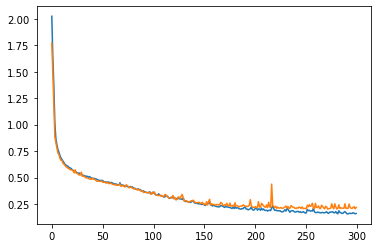

In [160]:
pl.plot(history.history['loss'][:300])
pl.plot(history.history['val_loss'][:300])

### Accuracy Evaluation

In [161]:
test_loss, test_accuracy = model.evaluate(X_test, Y_test)
print('Accuracy on test dataset:', test_accuracy)

101/101 [==============================] - 0s 813us/step - loss: 0.1699 - accuracy: 0.9532
Accuracy on test dataset: 0.9532418847084045


### Predictions

In [162]:
X = pavia.reshape(-1, pavia.shape[2])
X = normalize(X)
print(X.shape)

(207400, 103)


In [163]:
predictions = model.predict(X)
print(predictions.shape)

(207400, 10)


In [164]:
pavia_predict = np.argmax(predictions, axis=1).reshape(610, 340)
print(pavia_predict.shape)


(610, 340)


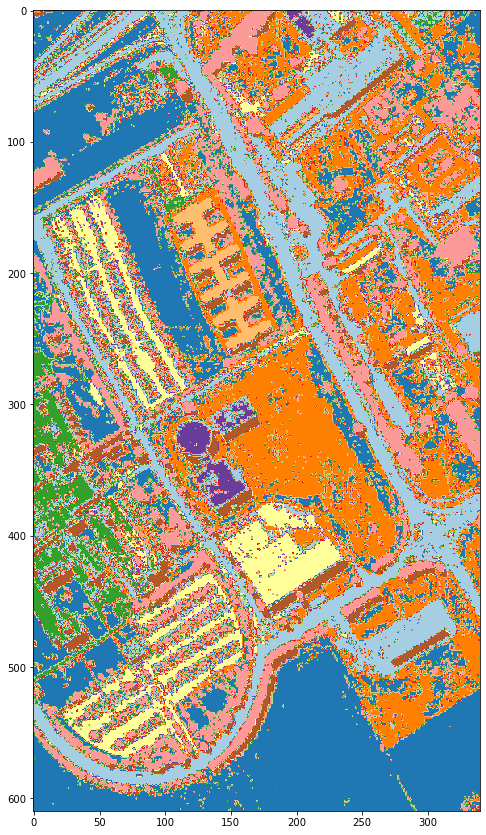

In [165]:
#pavia_predict[0,0] = 0

pl.figure(figsize=(8,16))
pl.imshow(pavia_predict,cmap='Paired')
pl.show()

### Saving models and corresponding predictions for later use

In [166]:
# save he model

#last accuracy on validation set
last_val_accuracy = history.history['val_accuracy'][-1]
last_val_accuracy_str = str(last_val_accuracy).replace('.', '_')

model_name = 'model_'+last_val_accuracy_str+'.h5'

model.save(model_name)

In [167]:
predictions_file_name = 'pavia_predictions_'+last_val_accuracy_str
np.save(predictions_file_name, pavia_predict)